<a href="https://colab.research.google.com/github/nakanoelio/i2a2-challenge-petr4-trad-sys/blob/main/I2A2_PETR4_Naive_Bayes_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install --upgrade mplfinance

#Instalação da Biblioteca TA-lib
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

     |████████████████████████████████| 6.3MB 31.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=4d074aa0cc844037e538bd049856a35f02995a6fd35eb9a9b258e2d1dc138b60
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 71kB 8.1MB/s 
Selecting previously unselected package libta-lib0.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing tri

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sn
import matplotlib.pyplot as plt

import yfinance as yf

import talib as ta

from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

In [ ]:
%matplotlib inline

In [ ]:
stock_ticker = 'PETR4.SA'
start_date = '2015-11-30'
end_date = '2021-5-27'

yf_petr4 = yf.Ticker(stock_ticker)
df_petr4 = yf_petr4.history(start=start_date, end=end_date)

stock_ticker = '^BVSP'
yf_ibov = yf.Ticker(stock_ticker)
df_ibov = yf_ibov.history(start=start_date, end=end_date)

In [ ]:
df_ibov["Close"].pct_change().describe()

count    1353.000000
mean        0.000900
std         0.017359
min        -0.147797
25%        -0.007222
50%         0.001110
75%         0.009842
max         0.139082
Name: Close, dtype: float64

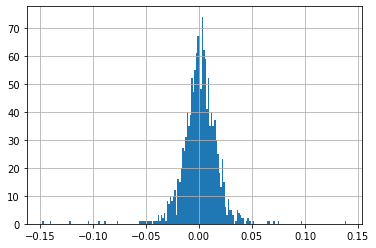

In [ ]:
df_ibov["Close"].pct_change().hist(bins=200)

In [ ]:
df_petr4["Close"].pct_change().describe()

count    1359.000000
mean        0.001539
std         0.033059
min        -0.296978
25%        -0.013350
50%         0.001276
75%         0.016689
max         0.222222
Name: Close, dtype: float64

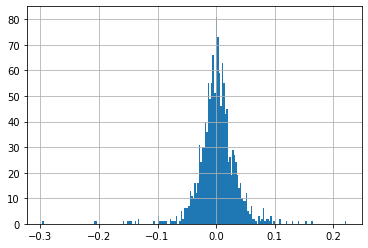

In [ ]:
df_petr4["Close"].pct_change().hist(bins=200)

In [ ]:
df_petr4

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-11-30,6.767124,7.036373,6.659424,6.883799,72764300,0.0,0
2015-12-01,6.883799,6.964574,6.686350,6.722250,35865600,0.0,0
2015-12-02,6.767124,6.811999,6.596599,6.749174,47713500,0.0,0
2015-12-03,7.170996,7.332546,6.991497,7.162022,76680900,0.0,0
2015-12-04,7.153047,7.153047,6.659424,6.749174,63662600,0.0,0
...,...,...,...,...,...,...,...
2021-05-20,26.150000,26.280001,25.719999,25.930000,71371100,0.0,0
2021-05-21,26.080000,26.309999,25.940001,25.950001,82884500,0.0,0
2021-05-24,26.280001,26.520000,25.990000,26.389999,63029600,0.0,0


In [ ]:
#Calculo dos Indicadores
def indicadores(stock_data):
    
    data = stock_data.copy()
    data['W%R'] = ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14) #Retorna valor do indicador Williams %R
    data['MACD'], data['Signal-line'], data['Histograma_MACD'] = ta.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9) #Valores do indicador MACD
    data.loc[:, 'Momento_MACD']=np.where(data['Histograma_MACD']>0, 1, 0) #Retorna 1 para compra pelo MACD (momento positivo), 0 para venda
    data['Tendencia_MACD']=np.where(data['Histograma_MACD'].diff()>0, 1, 0) #Derivada, sinaliza reversao de tendencia no histograma MACD, 1 para compra, 0 para venda
    data.loc[:, 'W%R_Compra']= np.where(data['W%R']<-80, 1, 0) # Retorna 1 para sinal de compra, caso Williams %R < -80
    data.loc[:, 'W%R_Venda']= np.where(data['W%R']>-20, 1, 0)  # Retorna 1 para sinal de venda, caso Williams %R > -20

    return data.drop(["Open","Close","High","Low","Volume","Dividends","Stock Splits"],axis="columns")

In [ ]:
def isSupport(df,i):
    #Estamos utilizando dados futuros!
    support = df['Low'][i] <= df['Low'][i-1]  and df['Low'][i] <= df['Low'][i+1] and df['Low'][i] < df['Low'][i+2] and df['Low'][i] < df['Low'][i-2]
    
    return support

def isResistance(df,i):
    #Estamos utilizando dados futuros!
    resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] and df['High'][i] > df['High'][i+2] and df['High'][i] > df['High'][i-2]
    
    return resistance 

In [ ]:
def isFarFromLevel(l,levels,s):

   return np.sum([abs(l-x) < s  for x in levels]) == 0

In [ ]:
def sup_res(df_data):
    s =  np.mean(df_data['High'] - df_data['Low'])
    levels = []
    support = [0,0]
    resistance = [0,0]
    for i in range(2,df_data.shape[0]-2):
        if isSupport(df_data,i):
            l = df_data['Low'][i]
            support.append(1)
            resistance.append(0)
            levels.append((i,l))
            #if isFarFromLevel(l,levels,s):
                #support.append(1)
                #resistance.append(0)
                #levels.append((i,l))
            #else:
                #support.append(0)
                #resistance.append(0)
        elif isResistance(df_data,i):
            l = df_data['High'][i]
            support.append(0)
            resistance.append(1)
            #if isFarFromLevel(l,levels,s):
                #resistance.append(1)
                #support.append(0)
                #levels.append((i,l))
            #else:
                #resistance.append(0)
                #support.append(0)
        else:
            resistance.append(0)
            support.append(0)
    support.extend([0,0])
    resistance.extend([0,0])

    return support, resistance

In [ ]:
def feat_gen(data_f, p_window):
    return_period = 3
    data_frame = data_f.copy()

    data_frame["Close_Return"] = data_frame["Close"].diff()
    data_frame["Close_Return_Rel"] = data_frame["Close"].pct_change()
    
    #data_frame["Close_Return"].fillna(0,inplace=True)
    #data_frame["Close_Return_Rel"].fillna(0,inplace=True)
    tresh =  0
    #data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() > tresh, f"Expected_Close_Return_{return_period}"] = 3
    #data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() <= tresh, f"Expected_Close_Return_{return_period}"] = 2
    #data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() < -tresh, f"Expected_Close_Return_{return_period}"] = 1
    data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() >= tresh, f"Expected_Close_Return_{return_period}"] = 1
    data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() < tresh, f"Expected_Close_Return_{return_period}"] = 0
    new_col_names = []
    for i in range(1,p_window+1):
        data_frame[f'Lag_{i}period_CRR'] = data_frame["Close_Return_Rel"].shift(periods=i)

    data_frame["Expected_Close_Return"] = data_frame["Expected_Close_Return"].shift(-1)

    return data_frame.drop(["Open","Close","High","Low","Volume","Dividends","Stock Splits"],axis="columns")


In [ ]:
def calc_beta(data_frame_asset,data_frame_bench):
    data_frame_beta = pd.concat([data_frame_bench["Close"].pct_change(), data_frame_asset["Close"].pct_change()],axis=1,ignore_index=True)

    data_frame_beta.columns=["Close_IBOV","Close_PETR4"]

    data_frame_beta["Beta"] = data_frame_beta["Close_PETR4"].rolling(30).cov(data_frame_beta["Close_IBOV"].rolling(30))/data_frame_beta["Close_IBOV"].rolling(30).var()

    data_frame_beta["Beta_expected_PETR4"] = data_frame_beta["Close_IBOV"]*data_frame_beta["Beta"]

    data_frame_beta["PETR4_Excess_Variat"] = (data_frame_beta["Close_PETR4"] - data_frame_beta["Beta_expected_PETR4"])/data_frame_beta["Beta_expected_PETR4"]
    data_frame_beta["PETR4_Excess_Variat"].describe()
    var_tolerance = 1#data_frame_beta["Close_IBOV"].std()#/data_frame_beta["Close_IBOV"].mean()

    data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"]  > var_tolerance, "PETR4_Excess_Variat_Disc"] = 3
    data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"] <= var_tolerance , "PETR4_Excess_Variat_Disc"] = 2
    data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"]  < -var_tolerance, "PETR4_Excess_Variat_Disc"] = 1

    return data_frame_beta.drop(["Close_IBOV","Close_PETR4"],axis="columns")

In [ ]:
df_petr4_ind = df_petr4

In [ ]:
p_window = 4
df_petr4_ind = pd.concat([df_petr4,feat_gen(df_petr4, p_window)],axis=1)
df_petr4_ind = pd.concat([df_petr4_ind,indicadores(df_petr4)],axis=1)
sup,res = sup_res(df_petr4)
df_petr4_ind["Support"] = sup
df_petr4_ind["Resistance"] = res
df_petr4_ind = pd.concat([df_petr4_ind,calc_beta(df_petr4,df_ibov)],axis=1)
df_petr4_ind = df_petr4_ind.reindex(columns=(list([col for col in df_petr4_ind.columns if col != "Expected_Close_Return"]+["Expected_Close_Return"]) ))

In [ ]:
print(sup)
print(res)


[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

In [ ]:
df_petr4_ind.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Close_Return', 'Close_Return_Rel', 'Lag_1period_CRR',
       'Lag_2period_CRR', 'Lag_3period_CRR', 'Lag_4period_CRR', 'W%R', 'MACD',
       'Signal-line', 'Histograma_MACD', 'Momento_MACD', 'Tendencia_MACD',
       'W%R_Compra', 'W%R_Venda', 'Support', 'Resistance', 'Beta',
       'Beta_expected_PETR4', 'PETR4_Excess_Variat',
       'PETR4_Excess_Variat_Disc', 'Expected_Close_Return'],
      dtype='object')

In [ ]:
df_petr4_ind.corr()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_Return,Close_Return_Rel,Lag_1period_CRR,Lag_2period_CRR,Lag_3period_CRR,Lag_4period_CRR,W%R,MACD,Signal-line,Histograma_MACD,Momento_MACD,Tendencia_MACD,W%R_Compra,W%R_Venda,Support,Resistance,Beta,Beta_expected_PETR4,PETR4_Excess_Variat,PETR4_Excess_Variat_Disc,Expected_Close_Return
Open,1.000000,0.999246,0.998922,0.998191,0.087246,0.051357,NaN,-0.007370,-0.024962,0.011573,0.011246,0.012544,0.013599,0.085830,0.225403,0.239771,0.003336,-0.000280,0.000224,-0.094113,0.009201,-0.039003,0.037064,-0.594292,-0.031663,0.047501,-4.328307e-02,-4.445316e-02
High,0.999246,1.000000,0.998615,0.998998,0.104146,0.052661,NaN,0.008780,-0.009460,0.011221,0.008627,0.010957,0.013838,0.091166,0.219056,0.233066,0.003102,0.001274,0.012641,-0.098504,0.013718,-0.038523,0.039939,-0.590784,-0.022696,0.047326,-3.971524e-02,-4.666109e-02
Low,0.998922,0.998615,1.000000,0.999161,0.066018,0.051203,NaN,0.017377,-0.002931,0.016361,0.013622,0.018145,0.018356,0.102910,0.236230,0.246025,0.019104,0.007425,0.013151,-0.109073,0.022913,-0.047253,0.036181,-0.598494,-0.014725,0.046198,-4.255661e-02,-4.607391e-02
Close,0.998191,0.998998,0.999161,1.000000,0.083352,0.052366,NaN,0.036731,0.016060,0.010535,0.010938,0.015848,0.015552,0.109576,0.228810,0.239286,0.015571,0.008274,0.026338,-0.114221,0.028847,-0.041898,0.033414,-0.594498,-0.000621,0.046054,-3.981072e-02,-4.890292e-02
Volume,0.087246,0.104146,0.066018,0.083352,1.000000,-0.005244,NaN,-0.108527,-0.035496,-0.061094,-0.048578,-0.049239,-0.025181,-0.078491,-0.243106,-0.221623,-0.113280,0.014710,0.061285,0.119651,-0.033378,0.063823,0.058962,0.141781,-0.046490,0.015022,8.126902e-02,6.103127e-03
Dividends,0.051357,0.052661,0.051203,0.052366,-0.005244,1.000000,NaN,0.006768,0.006806,0.010342,-0.018707,0.013570,-0.022718,-0.017315,-0.018226,-0.016256,-0.009558,0.005396,0.011266,-0.027231,-0.041742,0.023238,0.027177,-0.033199,-0.006486,-0.008075,-7.613331e-02,-6.382961e-02
Stock Splits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Close_Return,-0.007370,0.008780,0.017377,0.036731,-0.108527,0.006768,NaN,1.000000,0.918598,-0.062276,-0.002486,0.062040,-0.003901,0.400517,0.073548,-0.001755,0.238354,0.149103,0.449745,-0.345710,0.313004,-0.151419,0.040441,-0.006727,0.746285,-0.008747,4.932522e-02,-7.519487e-02
Close_Return_Rel,-0.024962,-0.009460,-0.002931,0.016060,-0.035496,0.006806,NaN,0.918598,1.000000,-0.083347,-0.011749,0.084264,-0.010302,0.404331,0.050085,-0.020517,0.219628,0.149592,0.447054,-0.348040,0.323412,-0.163751,0.038378,0.026021,0.832348,-0.018923,5.200553e-02,-7.203440e-02
Lag_1period_CRR,0.011573,0.011221,0.016361,0.010535,-0.061094,0.010342,NaN,-0.062276,-0.083347,1.000000,-0.083240,-0.011834,0.084270,0.296703,0.095314,0.004329,0.289307,0.193304,0.255925,-0.218195,0.226549,-0.198366,0.250646,0.005163,-0.092053,0.038178,-1.272742e-02,2.862258e-03


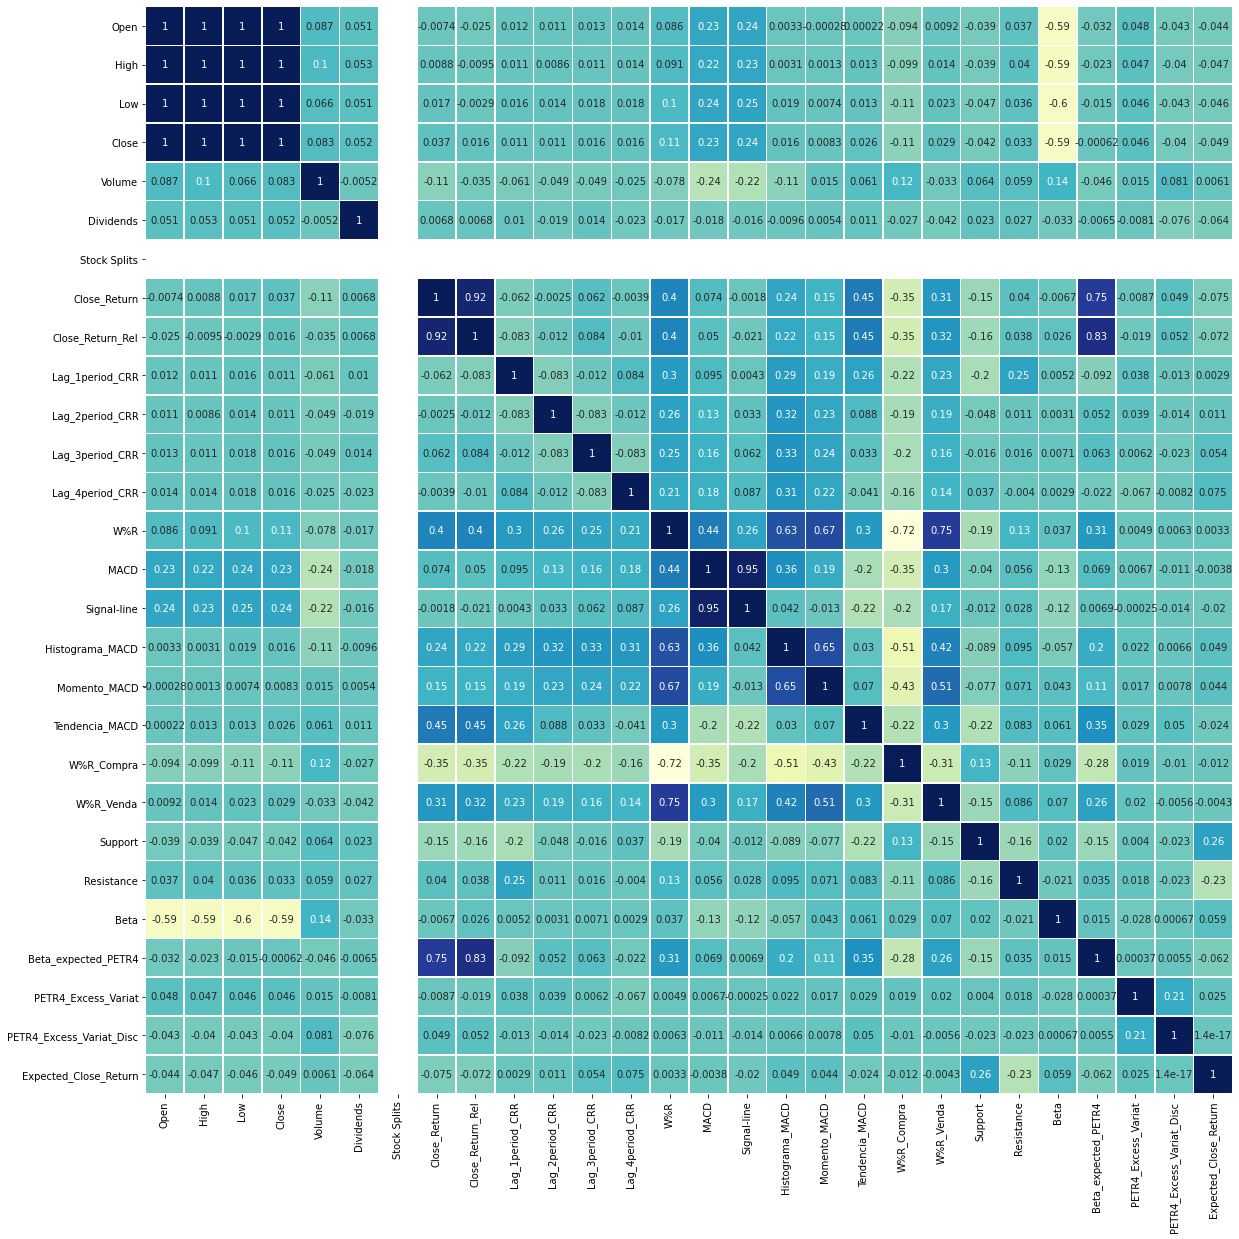

In [ ]:
fig,ax = plt.subplots(1,figsize=(20,20))
fig.patch.set_facecolor('xkcd:white')
ax = sn.heatmap(df_petr4_ind.corr(),linewidths=.5,annot=True,cmap="YlGnBu",cbar=False,square=True)


In [ ]:
g = sn.PairGrid(df_petr4_ind)
g.map(sn.scatterplot)

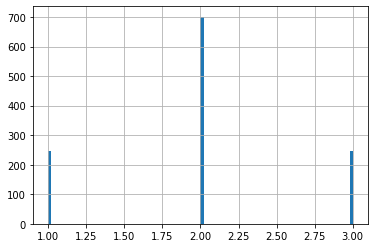

In [ ]:
df_petr4_ind["PETR4_Excess_Variat_Disc"].hist(bins=100)

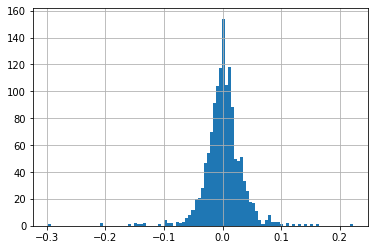

In [ ]:
df_petr4_ind["Close_Return_Rel"].hist(bins=100)

In [ ]:
((df_petr4_ind["Close_Return_Rel"]-df_petr4_ind["Close_Return_Rel"].mean())/df_petr4_ind["Close_Return_Rel"].std()).describe()

count    1.359000e+03
mean    -5.977967e-17
std      1.000000e+00
min     -9.029939e+00
25%     -4.503958e-01
50%     -7.956250e-03
75%      4.582714e-01
max      6.675502e+00
Name: Close_Return_Rel, dtype: float64

In [ ]:
dia_ini_train_idx = df_petr4_ind.index.get_loc("2016-01-26 00:00:00")
dia_fin_train_idx = df_petr4_ind.index.get_loc("2018-01-26 00:00:00")
y_label_idx = df_petr4_ind.columns.get_loc("Expected_Close_Return")

In [ ]:
X = df_petr4_ind.iloc[dia_ini_train_idx:dia_fin_train_idx-100].drop("Expected_Close_Return",axis='columns')
X_test = df_petr4_ind.iloc[dia_fin_train_idx-100:dia_fin_train_idx].drop("Expected_Close_Return",axis='columns')
y = df_petr4_ind.iloc[dia_ini_train_idx:dia_fin_train_idx-100,y_label_idx]
y_test = df_petr4_ind.iloc[dia_fin_train_idx-100:dia_fin_train_idx,y_label_idx]

In [ ]:
def run_model(X,y,X_test,y_test,model_type):

    nb_model = model_type
    nb_model.fit(X, y)

    y_pred = nb_model.predict(X_test)
    print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
    print("Accuracy: %f"% metrics.balanced_accuracy_score(y_test, y_pred))
    #print("Precision: %d"% metrics.precision_score(y_test,y_pred))
    cf_train2 = metrics.confusion_matrix(y_test, y_pred, normalize="all")                                  
    sn.heatmap(cf_train2,linewidths=.5,annot=True,cmap="YlGnBu",cbar=False,square=True,xticklabels=(1,2,3), yticklabels=(1,2,3))
    
    return nb_model

In [ ]:
gnb = run_model(X,y,X_test,y_test,GaussianNB())

ValueError: ignored

Number of mislabeled points out of a total 100 points : 19
Accuracy: 0.835714


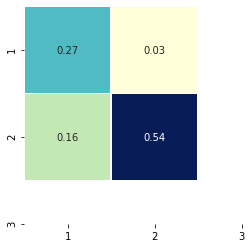

In [ ]:
bnb = run_model(X,y,X_test,y_test,BernoulliNB())

In [ ]:
print(np.column_stack((y_test.to_list(),bnb.predict(X_test),)))
print(bnb.predict_proba(X_test))
print(bnb.score(X_test,y_test))

[[1. 1.]
 [3. 3.]
 [1. 1.]
 [3. 3.]
 [3. 1.]
 [2. 1.]
 [2. 3.]
 [3. 3.]
 [3. 1.]
 [1. 1.]
 [3. 3.]
 [3. 1.]
 [1. 1.]
 [1. 3.]
 [3. 3.]
 [1. 1.]
 [3. 3.]
 [3. 1.]
 [1. 1.]
 [3. 3.]
 [1. 1.]
 [3. 3.]
 [3. 1.]
 [1. 1.]
 [2. 3.]
 [2. 1.]
 [3. 3.]
 [3. 1.]
 [3. 1.]
 [1. 1.]
 [3. 3.]
 [1. 1.]
 [3. 3.]
 [3. 1.]
 [3. 1.]
 [3. 1.]
 [1. 1.]
 [1. 3.]
 [3. 3.]
 [2. 1.]
 [3. 1.]
 [3. 1.]
 [1. 1.]
 [3. 3.]
 [1. 1.]
 [2. 3.]
 [1. 3.]
 [1. 3.]
 [2. 3.]
 [3. 1.]
 [3. 1.]
 [2. 1.]
 [1. 1.]
 [3. 1.]
 [3. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [3. 1.]
 [3. 1.]
 [1. 1.]
 [1. 1.]
 [3. 1.]
 [1. 1.]
 [3. 3.]
 [3. 1.]
 [3. 1.]
 [1. 1.]
 [1. 3.]
 [1. 1.]
 [3. 1.]
 [1. 1.]
 [3. 1.]
 [3. 1.]
 [1. 1.]
 [2. 1.]
 [3. 1.]
 [3. 1.]
 [3. 1.]
 [2. 1.]
 [3. 1.]
 [3. 1.]
 [3. 1.]
 [3. 1.]
 [3. 1.]
 [2. 1.]
 [1. 3.]
 [3. 3.]
 [3. 1.]
 [3. 1.]
 [3. 1.]
 [3. 1.]
 [1. 1.]
 [3. 3.]
 [3. 1.]
 [1. 1.]
 [3. 3.]
 [2. 1.]
 [3. 1.]]
[[0.69351009 0.06363592 0.24285399]
 [0.4348389  0.00155954 0.56360156]
 [0.57516019 0.00293872 0.4

In [ ]:
comnb = run_model(X,y,X_test,y_test,ComplementNB())

ValueError: ignored

In [ ]:
catnb = run_model(X,y,X_test,y_test,CategoricalNB())